**Load pretrained DiT and VAE**

In [15]:
import os, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../../fast-DiT")

from models import DiT_models
from diffusion import create_diffusion  # diffusion scheduler/factory
from download import find_model         # auto-download checkpoints
from diffusers.models import AutoencoderKL

device = "mps" if torch.backends.mps.is_available() else "cpu"
image_size = 256
latent = image_size // 8

model = DiT_models["DiT-XL/2"](input_size=latent, num_classes=1000).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict); model.eval()


diffusion = create_diffusion("64")
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)

**Conditional generation with CFG**

  0%|          | 0/64 [00:00<?, ?it/s]

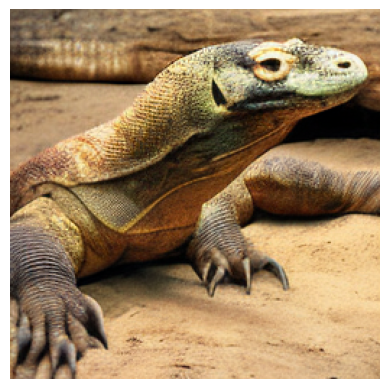

In [14]:
# one sample at class 207 (golden retriever)
y = torch.tensor([48, 1000], device=device)    # CFG: 207 + null class
z = torch.randn(2, 4, latent, latent, device=device)


# cast any float64 numpy arrays inside the diffusion object to float32
for k, v in list(diffusion.__dict__.items()):
    if isinstance(v, np.ndarray) and v.dtype == np.float64:
        diffusion.__dict__[k] = v.astype(np.float32)

with torch.no_grad():
    latents = diffusion.p_sample_loop(
        model.forward_with_cfg, z.shape, z,
        clip_denoised=False, model_kwargs=dict(y=y, cfg_scale=4.0),
        progress=True, device=device
    )
    sample = latents[:1] / 0.18215
    img = vae.decode(sample).sample  # (1,3,256,256)

# img is (1, 3, 256, 256) in [-1, 1]
img_vis = img[0].detach().float().clamp(-1, 1)        # (3,H,W)
img_vis = (img_vis + 1) * 0.5                         # -> [0,1]
img_np  = img_vis.permute(1, 2, 0).cpu().numpy()      # (H,W,3) for plt

plt.imshow(img_np)
plt.axis("off")
plt.show()

**Unconditional Generation**

In [38]:
# assumes: model, diffusion, vae, image_size, latent, device already defined
# image_size in {256, 512}; latent = image_size // 8

import torch

n = 1  # how many images to generate
# Unconditional label = num_classes (ImageNet has 1000 classes, so null is 1000)
y = torch.full((n,), 1000, device=device, dtype=torch.long)

# Initial noise in VAE latent space (4 channels, downsampled by 8)
z = torch.randn(n, 4, latent, latent, device=device)

with torch.no_grad():
    latents = diffusion.p_sample_loop(
        model,                     # NOTE: not forward_with_cfg
        z.shape, z,
        clip_denoised=False,
        model_kwargs=dict(y=y),    # pass the null class labels
        progress=True,
        device=device
    )
    # SD VAE expects latents scaled by 1/0.18215
    img = vae.decode(latents / 0.18215).sample   # (n,3,H,W), in [-1,1]

# img is (1, 3, 256, 256) in [-1, 1]
img_vis = img[0].detach().float().clamp(-1, 1)        # (3,H,W)
img_vis = (img_vis + 1) * 0.5                         # -> [0,1]
img_np  = img_vis.permute(1, 2, 0).cpu().numpy()      # (H,W,3) for plt

plt.imshow(img_np)
plt.axis("off")
plt.show()

  0%|          | 0/64 [00:00<?, ?it/s]

/Users/pman0581/miniconda3/envs/uno/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/Users/pman0581/miniconda3/envs/uno/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [16]:
import torch, inspect
from collections import OrderedDict

device = next(model.parameters()).device
latent = image_size // 8

# ---- A) Model summary & param counts
def count_params(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, trainable

total, trainable = count_params(model)
print(f"Total params: {total/1e6:.2f}M | Trainable: {trainable/1e6:.2f}M")

print("\nTop-level children & their param counts:")
for name, child in model.named_children():
    c_total, _ = count_params(child)
    print(f"  {name:<20} {c_total/1e6:>8.2f}M")

# Positional/embed info if present
for attr in ["pos_embed", "x_embedder", "t_embedder", "y_embedder", "blocks", "final_layer"]:
    if hasattr(model, attr):
        val = getattr(model, attr)
        shape = getattr(val, "shape", None)
        if shape is not None:
            print(f"{attr}: shape={tuple(shape)}")
        else:
            print(f"{attr}: type={type(val)}")

# If blocks exist, show first block details
if hasattr(model, "blocks") and len(model.blocks) > 0:
    b0 = model.blocks[0]
    print("\nFirst transformer block details:")
    print(b0)
    # try to print attention heads if the attribute exists
    num_heads = getattr(getattr(b0, "attn", b0), "num_heads", None)
    if num_heads is not None:
        print("num_heads:", num_heads)

# ---- B) Forward hooks to capture tensor shapes through key modules
shapes = OrderedDict()

def hooker(name):
    def fn(module, inp, out):
        def _shape(x):
            if isinstance(x, (tuple, list)) and len(x) > 0:
                return tuple(xi.shape for xi in x if hasattr(xi, "shape"))
            return getattr(x, "shape", None)
        shapes[name] = {"in": _shape(inp), "out": _shape(out)}
    return fn

hooks = []
def try_hook(mod, name):
    try:
        h = mod.register_forward_hook(hooker(name))
        hooks.append(h)
    except Exception as e:
        pass

# Register hooks on common DiT parts if they exist
if hasattr(model, "x_embedder"):   try_hook(model.x_embedder, "x_embedder")
if hasattr(model, "t_embedder"):   try_hook(model.t_embedder, "t_embedder")
if hasattr(model, "y_embedder"):   try_hook(model.y_embedder, "y_embedder")

# A few early/mid/late blocks
if hasattr(model, "blocks") and len(model.blocks) > 0:
    ids = [0, len(model.blocks)//2, len(model.blocks)-1]
    seen = set()
    for i in ids:
        if i in seen or i >= len(model.blocks): 
            continue
        seen.add(i)
        blk = model.blocks[i]
        try_hook(blk, f"block[{i}]")
        # submodules if present
        if hasattr(blk, "attn"): try_hook(blk.attn, f"block[{i}].attn")
        if hasattr(blk, "mlp"):  try_hook(blk.mlp,  f"block[{i}].mlp")

if hasattr(model, "final_layer"):
    try_hook(model.final_layer, "final_layer")

# ---- C) Run a single dummy forward to populate hook shapes
model.eval()
with torch.no_grad():
    x = torch.randn(1, 4, latent, latent, device=device)         # latent input
    t = torch.zeros(1, device=device, dtype=torch.long)          # timestep 0
    NULL = getattr(model, "num_classes", 1000)                   # null/uncond class
    y = torch.full((1,), NULL, device=device, dtype=torch.long)  # unconditional
    _ = model(x, t, y)

# Print captured shapes
print("\nCaptured module I/O shapes:")
for k, v in shapes.items():
    print(f"{k:18} in: {v['in']}  -> out: {v['out']}")

# Clean up hooks
for h in hooks:
    h.remove()


Total params: 675.13M | Trainable: 674.83M

Top-level children & their param counts:
  x_embedder               0.02M
  t_embedder               1.62M
  y_embedder               1.15M
  blocks                 669.34M
  final_layer              2.69M
pos_embed: shape=(1, 256, 1152)
x_embedder: type=<class 'timm.layers.patch_embed.PatchEmbed'>
t_embedder: type=<class 'models.TimestepEmbedder'>
y_embedder: type=<class 'models.LabelEmbedder'>
blocks: type=<class 'torch.nn.modules.container.ModuleList'>
final_layer: type=<class 'models.FinalLayer'>

First transformer block details:
DiTBlock(
  (norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
  (attn): Attention(
    (qkv): Linear(in_features=1152, out_features=3456, bias=True)
    (q_norm): Identity()
    (k_norm): Identity()
    (attn_drop): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (proj): Linear(in_features=1152, out_features=1152, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (norm2): Lay

In [26]:
def freeze_except_y_and_lastK_adaln(model, K=4, unfreeze_final_layer=False):
    """
    Freeze everything except:
      - y_embedder (always)
      - adaLN_modulation in the last K transformer blocks
      - (optional) final_layer if unfreeze_final_layer=True

    Returns:
      model, stats  (where stats is a dict with param counts)
    """
    # 1) Freeze all
    for p in model.parameters():
        p.requires_grad = False

    trainable_names = []

    # 2) y_embedder
    y_params = 0
    if hasattr(model, "y_embedder"):
        for n, p in model.y_embedder.named_parameters(prefix="y_embedder"):
            p.requires_grad = True
            y_params += p.numel()
            trainable_names.append(n)

    # 3) last-K adaLN_modulation
    adaln_params = 0
    num_blocks = len(getattr(model, "blocks", []))
    K = max(0, min(K, num_blocks))  # clamp
    if num_blocks and K > 0:
        for i, blk in enumerate(model.blocks):
            if i >= num_blocks - K and hasattr(blk, "adaLN_modulation"):
                for n, p in blk.adaLN_modulation.named_parameters(prefix=f"blocks.{i}.adaLN_modulation"):
                    p.requires_grad = True
                    adaln_params += p.numel()
                    trainable_names.append(n)

    # 4) optional final_layer
    final_params = 0
    if unfreeze_final_layer and hasattr(model, "final_layer"):
        for n, p in model.final_layer.named_parameters(prefix="final_layer"):
            p.requires_grad = True
            final_params += p.numel()
            trainable_names.append(n)

    # 5) counts
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    stats = {
        "total_params": total_params,
        "trainable_params": trainable_params,
        "breakdown": {
            "y_embedder": y_params,
            "adaLN_modulation_lastK": adaln_params,
            "final_layer": final_params,
        },
        "K": K,
        "num_blocks": num_blocks,
        "trainable_names": trainable_names,  # for quick inspection
    }

    # Nice printout
    def _mk(m): return f"{m/1e6:.2f}M"
    print(f"Total params:     {_mk(total_params)}")
    print(f"Trainable params: {_mk(trainable_params)}  "
          f"(y: {_mk(y_params)}, adaLN_last{K}: {_mk(adaln_params)}, final: {_mk(final_params)})")

    return model, stats


In [40]:
freeze_except_y_and_lastK_adaln(model, K=2, unfreeze_final_layer=True);

Total params:     675.13M
Trainable params: 19.79M  (y: 1.15M, adaLN_last2: 15.94M, final: 2.69M)


In [37]:
# quick sanity checks
print(any('cross' in n.lower() for n, _ in model.named_modules()))  # -> False
print([type(m).__name__ for _, m in model.named_modules() if 'Attn' in type(m).__name__ or 'Attention' in type(m).__name__])
# you'll see only 'Attention' (self-attn) modules

False
['Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention', 'Attention']
